In [1]:
import os
import types
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
from matplotlib.colors import LightSource
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib notebook

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

import cv2
import pyproj
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import cmocean
import pandas as pd
import rioxarray as rxr

from pathlib import Path
from IPython.display import display

# Open datasets used for visualisation

In [2]:
data_dir = Path(os.path.dirname(os.path.abspath("__file__"))).parent.joinpath('data')

# Dataset for ground water model (concentrations)
# Dataset ds is ordered with (z,y,x) coordinates
ds = xr.open_dataset(data_dir.joinpath('concentratie_data_gw_model.nc'))
# Replace negative concentrations (due to model errors) with 0
ds = ds.where((ds.conc >= 0) | ds.isnull(), other = 0)

# Dataset for ground water depth
ds_d = xr.open_dataset(data_dir.joinpath('depth.nc'))
# Rename variable name to depth
ds_d = ds_d.rename({'__xarray_dataarray_variable__':'depth'})

# Dataset for ground water level (not in github due to size)
ds_h = xr.open_dataset(data_dir.joinpath('heads.nc'))

# Dataset for wadsea water level  (not in github due to size, can be found at p:\1204421-kpp-benokust\2020\4-Zeegaten\03_systeemsuppleties\basis_model\fm\DFM_OUTPUT_wadsea\)
ds_wl = xr.open_dataset(data_dir.joinpath('wadsea_0000_map.nc'))

# Dataset of bathymetry
ds_b0 = rxr.open_rasterio(data_dir.joinpath('originele_bodem.tif'))

# Read satellite image with surrounding sea
sat = mpimg.imread(data_dir.joinpath('terschelling-sat2.png'))

# Read satellite image without surrounding sea
sat_2 = mpimg.imread(data_dir.joinpath('terschelling-sat2-removebg-preview.png'))

# Read image of water texture
water_img = cv2.imread(str(data_dir.joinpath('water.jpg')))

# Define extent for datasets

In [3]:
extent = ds.x.values.min(), ds.x.values.max(), ds.y.values.min(), ds.y.values.max()

# Grid for chosen area of Terschelling (for the bathymetry)
x_b0, y_b0 = np.array(ds_b0.x[1201:2970]), np.array(ds_b0.y[1435:2466])
X_b0, Y_b0 = np.meshgrid(ds_b0.x[1201:2969], ds_b0.y[1435:2466])
bodem0 = np.array(ds_b0[0,1435:2466,1201:2970])
bodem0[np.where(bodem0 == -9999)] = -43.8

# Obtain gridpoints from waterlevel model output which are within the bounds
x_grid, y_grid = ds_wl.mesh2d_face_x, ds_wl.mesh2d_face_y
terschelling_area = []
for i in range(x_grid.size):
    if x_grid[i] >= extent[0] and x_grid[i] <= extent[1] and y_grid[i] >= extent[2] and y_grid[i] <= extent[3]:
        terschelling_area.append(i)
        
# Get grid cells and waterlevels in defined area
x_grid_t, y_grid_t = x_grid[terschelling_area], y_grid[terschelling_area]
wl_t = ds_wl.mesh2d_s1[:,terschelling_area]

# High water and low water
wl_h = 1.55 # at time step 114
wl_l = -1.32 # at time step 400

# Lightsource for shadow in bathymetry dataset
ls = LightSource(azdeg=315, altdeg=45)

# Create shaded images

In [4]:
# Create shade using lightsource
rgb = ls.hillshade(bodem0,
               vert_exag=5, dx=20, dy=20)
# Scale satellite image to bathymetry shapes
sat_scaled = cv2.resize(sat, dsize=(bodem0.shape[1], bodem0.shape[0]), interpolation=cv2.INTER_CUBIC)
sat_scaled = sat_scaled.astype('float64')

# Add shade to scaled image
img_shade = ls.shade_rgb(sat_scaled, bodem0, vert_exag=5, blend_mode='soft')

# Repeat for satellite image without surrounding water
sat_2_scaled = cv2.resize(sat_2, dsize=(bodem0.shape[1], bodem0.shape[0]), interpolation=cv2.INTER_CUBIC)
sat_2_scaled[:,:,:3] = img_shade[:,:,:3]
img_sat_2 = sat_2_scaled

# Slider for ground water (in x-direction)

<IPython.core.display.Javascript object>


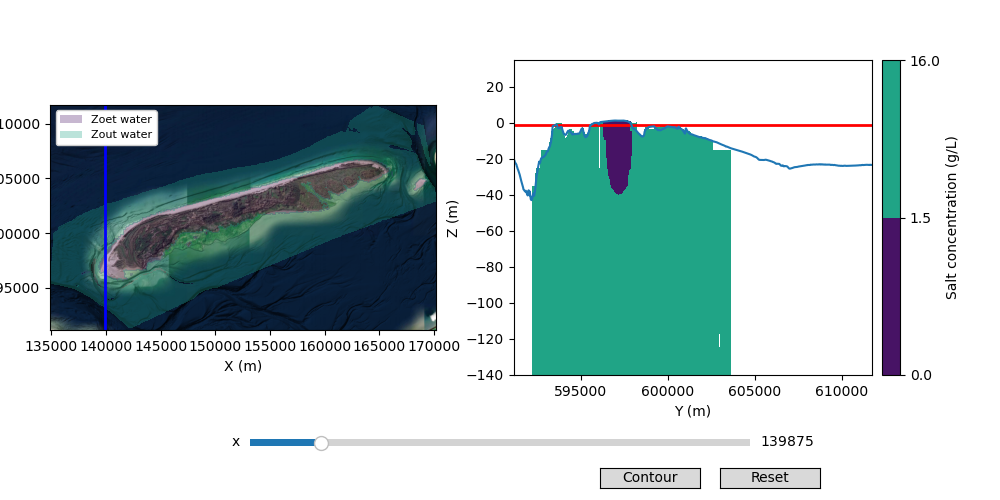

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [5]:
Y1, Z1 = np.meshgrid(ds.y, ds.z)
X2, Y2 = np.meshgrid(ds.x, ds.y)

# Define initial parameters
init_x = extent[0]+5000

fig, axes = plt.subplots(figsize=(10,5), ncols=2)

# adjust the main plot to make room for the slider
fig.subplots_adjust(left=0.05, bottom=0.25)

sat = mpimg.imread('terschelling-sat2.png')
im_sat = axes[0].imshow(img_shade, extent=extent)
im_c = axes[0].contourf(X2, Y2, ds.conc[-10,:,:], levels = [0,1.5,16], vmin=0, vmax=15, extent=extent, alpha=0.3)

line, = axes[0].plot([extent[0]+5000, extent[0]+5000], [extent[2], extent[3]],
         color='blue', linewidth=2)
line2, = axes[1].plot([extent[2], extent[3]], [wl_l, wl_l],
            color='red', linewidth=2)

axes[0].set_xlabel('X (m)')
axes[0].set_ylabel('Y (m)')
nm, lbl = im_c.legend_elements()
lbl[0]= 'Zoet water'
lbl[1] = 'Zout water'
legend = axes[0].legend(nm, lbl, fontsize= 8, loc='upper left', framealpha=1) 

# Calculate index for bathymetry dataset (due to varying grid size)
x_index = int((init_x - extent[0]) / ds.dx.values)
if x_index%2 == 0:
    xb_index = int(2.5 * x_index)
else:
    xb_index = int(np.ceil(2.5 * x_index))
    
# pcolormesh is faster, but not as smooth as contourf
#im_x = axes[1].pcolormesh(Y1, Z1, ds.conc[:,:,int((init_x - extent[0]) / ds.dx.values)], vmin=0, vmax=15, cmap='cmo.haline')
im_x = axes[1].contourf(Y1, Z1, ds.conc[:,:,int((init_x - extent[0]) / ds.dx.values)], levels=[0,1.5,16], vmin=0, vmax=15)#, cmap='cmo.haline')
im_b = axes[1].plot(y_b0, bodem0[:, xb_index])

axes[1].set_ylim(-140, 35)
axes[1].set_xlabel('Y (m)')
axes[1].set_ylabel('Z (m)')


# Make a horizontal slider to control the position on the x-axis.
x_ax = fig.add_axes([0.25, 0.1, 0.5, 0.03])
x_slider = Slider(
    ax=x_ax,
    label='x',
    valmin=extent[0],
    valmax=extent[1],
    valinit=init_x,
    valstep=50,
)

# The function to be called anytime a slider's value changes
# Contour plot needs to be cleared then redrawn, pcolormesh can just be updated using set_array
def update(val):
    line.set_xdata([val, val])
    axes[1].cla()
    x_index = int((val - extent[0]) / ds.dx.values)
    if x_index%2 == 0:
        xb_index = int(2.5 * x_index)
    else:
        xb_index = int(np.ceil(2.5 * x_index))
    im_x = axes[1].contourf(Y1, Z1, ds.conc[:,:,x_index], levels=[0,1.5,16], vmin=0, vmax=15)#, cmap='cmo.haline')
    im_b = axes[1].plot(y_b0, bodem0[:, xb_index])
    #im_x.set_array(ds.conc[:,:,int((val - extent[0]) / ds.dx.values)].values.ravel())
    line2, = axes[1].plot([extent[2], extent[3]], [wl_h, wl_h],
            color='red', linewidth=2)
    axes[1].set_ylim(-140, 35)
    fig.canvas.draw_idle()
    #plt.draw()


# register the update function with each slider
x_slider.on_changed(update)

# Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
resetax = fig.add_axes([0.72, 0.025, 0.1, 0.04])
reset_button = Button(resetax, 'Reset', hovercolor='0.900')

contourax = fig.add_axes([0.6, 0.025, 0.1, 0.04])
contour_button = Button(contourax, 'Contour', hovercolor='0.900')


# Change the transparency for each individual element, especially the legend had to be made transparent partswise
# Contour plot does not have Artist, hence call Artist of im_c.collections
def contour(event):
    if matplotlib.artist.Artist.get_alpha(im_c.collections[0]) == 0.3:
        for c in im_c.collections:
            c.set_alpha(0)
        for i in range(2):
            legend.get_patches()[i].set(alpha=0)
            legend.get_texts()[i].set(alpha=0)
        legend.draw_frame(False)
        #legend = axes[0].legend(nm, lbl, fontsize= 8, loc='upper left', framealpha = 0) 
    else:
        for c in im_c.collections:
            c.set_alpha(0.3)
        for i in range(2):
            legend.get_patches()[i].set_alpha(0.3)
            legend.get_texts()[i].set_alpha(1)
        legend.draw_frame(True)
        #matplotlib.artist.Artist.set_alpha(im_c.collections[1], 0.3)
    fig.canvas.draw_idle()

def reset(event):
    freq_slider.reset()

divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.10)
plt.colorbar(im_x, cax=cax, label='Salt concentration (g/L)')
    
reset_button.on_clicked(reset)
contour_button.on_clicked(contour)

plt.show()

# Slider for ground water (in y-direction)

<IPython.core.display.Javascript object>


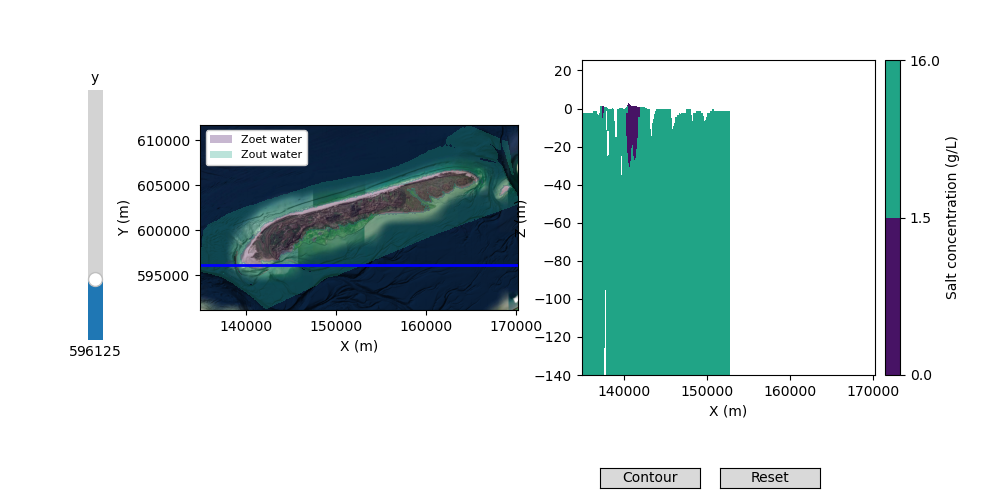

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [6]:
X1, Z1 = np.meshgrid(ds.x, ds.z)
X2, Y2 = np.meshgrid(ds.x, ds.y)

# Define initial parameters
init_x = extent[2]+5000

fig, axes = plt.subplots(figsize=(10,5), ncols=2)

# adjust the main plot to make room for the sliders
fig.subplots_adjust(left=0.2, bottom=0.25)

sat = mpimg.imread('terschelling-sat2.png')
im_sat = axes[0].imshow(img_shade, extent=extent)
im_c = axes[0].contourf(X2, Y2, ds.conc[-10,:,:], levels = [0,1.5,16], vmin=0, vmax=15, extent=extent, alpha=0.3)

#ax.set_extent([extent[0], extent[1], extent[2], extent[3]])
line, = axes[0].plot([extent[0], extent[1]], [extent[2] + 5000, extent[2] + 5000],
         color='blue', linewidth=2)
#line2, = axes[1].plot([extent[2], extent[3]], [-9.5, -9.5],
 #           color='red', linewidth=2)

axes[0].set_xlabel('X (m)')
axes[0].set_ylabel('Y (m)')
nm, lbl = im_c.legend_elements()
lbl[0]= 'Zoet water'
lbl[1] = 'Zout water'
legend = axes[0].legend(nm, lbl, fontsize= 8, loc='upper left', framealpha=1) 

#im_x = axes[1].pcolormesh(X1, Z1, ds.conc[:,int((init_x - extent[2]) / ds.dy.values),:], vmin=0, vmax=15, cmap='cmo.haline')
im_x = axes[1].contourf(X1, Z1, ds.conc[:,int((init_x - extent[2]) / ds.dy.values),:], levels=[0,1.5,16], vmin=0, vmax=15)#, cmap='cmo.haline')

axes[1].set_xlabel('X (m)')
axes[1].set_ylabel('Z (m)')


# Make a horizontal slider to control the frequency.
axfreq = fig.add_axes([0.08, 0.32, 0.03, 0.5])
freq_slider = Slider(
    ax=axfreq,
    label='y',
    valmin=extent[2],
    valmax=extent[3],
    valinit=init_x,
    valstep=50,
    orientation='vertical',
)

# The function to be called anytime a slider's value changes
def update(val):
    line.set_ydata([val, val])
    axes[1].cla()
    im_x = axes[1].contourf(X1, Z1, ds.conc[:,int((val - extent[2]) / ds.dy.values),:], levels=[0,1.5,16], vmin=0, vmax=15)#, cmap='cmo.haline')
    #im_x.set_array(ds.conc[:,int((val - extent[2]) / ds.dy.values),:].values.ravel())
    line2, = axes[1].plot([extent[0], extent[1]], [-9.5, -9.5],
            color='red', linewidth=2)
    fig.canvas.draw_idle()
    #plt.draw()


# register the update function with each slider
freq_slider.on_changed(update)

# Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
resetax = fig.add_axes([0.72, 0.025, 0.1, 0.04])
reset_button = Button(resetax, 'Reset', hovercolor='0.900')

buttonax = fig.add_axes([0.6, 0.025, 0.1, 0.04])
contour_button = Button(buttonax, 'Contour', hovercolor='0.900')


# Change the transparency for each individual element
def contour(event):
    if matplotlib.artist.Artist.get_alpha(im_c.collections[0]) == 0.3:
        for c in im_c.collections:
            c.set_alpha(0)
        for i in range(2):
            legend.get_patches()[i].set(alpha=0)
            legend.get_texts()[i].set(alpha=0)
        legend.draw_frame(False)
        #legend = axes[0].legend(nm, lbl, fontsize= 8, loc='upper left', framealpha = 0) 
    else:
        for c in im_c.collections:
            c.set_alpha(0.3)
        for i in range(2):
            legend.get_patches()[i].set_alpha(0.3)
            legend.get_texts()[i].set_alpha(1)
        legend.draw_frame(True)
        #matplotlib.artist.Artist.set_alpha(im_c.collections[1], 0.3)
    fig.canvas.draw_idle()

def reset(event):
    freq_slider.reset()

divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.10)
plt.colorbar(im_x, cax=cax, label='Salt concentration (g/L)')
    
reset_button.on_clicked(reset)
contour_button.on_clicked(contour)

plt.show()

# Slider for ground water (in z-direction)

<IPython.core.display.Javascript object>


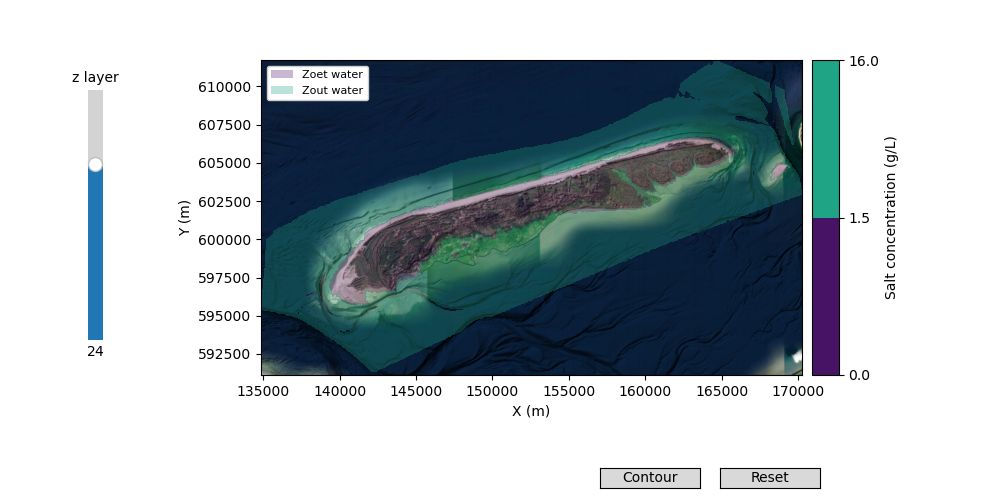

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [7]:
X1, Z1 = np.meshgrid(ds.x, ds.z)
X2, Y2 = np.meshgrid(ds.x, ds.y)

# Define initial parameters
init_x = 24

fig, axes = plt.subplots(figsize=(10,5), ncols=1)

# adjust the main plot to make room for the sliders
fig.subplots_adjust(left=0.2, bottom=0.25)

sat = mpimg.imread('terschelling-sat2.png')
im_sat = axes.imshow(img_shade, extent=extent)
im_c = axes.contourf(X2, Y2, ds.conc[-10,:,:], levels = [0,1.5,16], vmin=0, vmax=15, extent=extent, alpha=0.3)

axes.set_xlabel('X (m)')
axes.set_ylabel('Y (m)')
nm, lbl = im_c.legend_elements()
lbl[0]= 'Zoet water'
lbl[1] = 'Zout water'
legend = axes.legend(nm, lbl, fontsize= 8, loc='upper left', framealpha=1) 

# Make a horizontal slider to control the frequency.
axfreq = fig.add_axes([0.08, 0.32, 0.03, 0.5])
freq_slider = Slider(
    ax=axfreq,
    label='z layer',
    valmin=0,
    valmax=34,
    valinit=init_x,
    valstep=1,
    orientation='vertical',
)

# The function to be called anytime a slider's value changes
def update(val):
    axes.cla()
    im_sat = axes.imshow(img_shade, extent=extent)
    im_c = axes.contourf(X2, Y2, ds.conc[val,:,:], levels = [0,1.5,16], vmin=0, vmax=15, extent=extent, alpha=0.3)
    fig.canvas.draw_idle()
    #plt.draw()


# register the update function with each slider
freq_slider.on_changed(update)

# Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
resetax = fig.add_axes([0.72, 0.025, 0.1, 0.04])
reset_button = Button(resetax, 'Reset', hovercolor='0.900')

buttonax = fig.add_axes([0.6, 0.025, 0.1, 0.04])
contour_button = Button(buttonax, 'Contour', hovercolor='0.900')


# Change the transparency for each individual element
def contour(event):
    if matplotlib.artist.Artist.get_alpha(im_c.collections[0]) == 0.3:
        for c in im_c.collections:
            c.set_alpha(0)
        for i in range(2):
            legend.get_patches()[i].set(alpha=0)
            legend.get_texts()[i].set(alpha=0)
        legend.draw_frame(False)
        #legend = axes[0].legend(nm, lbl, fontsize= 8, loc='upper left', framealpha = 0) 
    else:
        for c in im_c.collections:
            c.set_alpha(0.3)
        for i in range(2):
            legend.get_patches()[i].set_alpha(0.3)
            legend.get_texts()[i].set_alpha(1)
        legend.draw_frame(True)
        #matplotlib.artist.Artist.set_alpha(im_c.collections[1], 0.3)
    fig.canvas.draw_idle()

def reset(event):
    freq_slider.reset()

divider = make_axes_locatable(axes)
cax = divider.append_axes('right', size='5%', pad=0.10)
plt.colorbar(im_x, cax=cax, label='Salt concentration (g/L)')
    
reset_button.on_clicked(reset)
contour_button.on_clicked(contour)

plt.show()

# Apply filter for drought

<IPython.core.display.Javascript object>


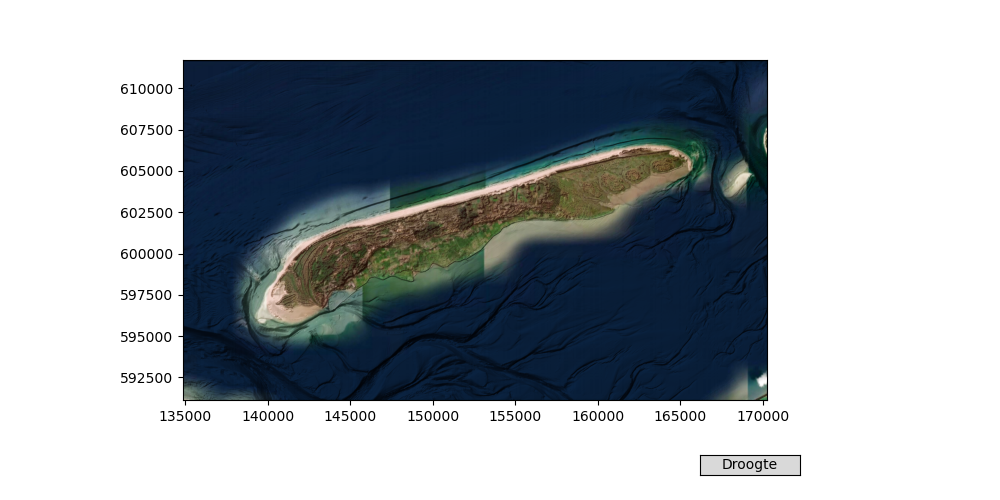

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.1

In [8]:
#extent = 0, loc_arr.shape[1], 0, loc_arr.shape[0]
cmap = matplotlib.cm.spring
cmap.set_bad(color='yellow')
img = sat_2
yel_filter = img[:,:,-1]
img[:,:,0] = yel_filter * 158
img[:,:,1] = yel_filter * 162 * 0
img[:,:,2] = yel_filter * 107 * 0

img2 = mpimg.imread('terschelling-sat2.png')
#plt.imshow(img, extent=extent)

fig, axes = plt.subplots(figsize=(10,5))
fig.subplots_adjust(left=0.05, bottom=0.2)
terschelling = axes.imshow(img_shade, extent=extent)
droogte_filter = axes.imshow(img, extent=extent, alpha=0.1)

# Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
buttonax = fig.add_axes([0.7, 0.05, 0.1, 0.04])
button = Button(buttonax, 'Droogte', hovercolor='0.975')


def droogte(event):
    if matplotlib.artist.Artist.get_alpha(droogte_filter) == 0.1:
        matplotlib.artist.Artist.set_alpha(droogte_filter, 0)
    else:
        matplotlib.artist.Artist.set_alpha(droogte_filter, 0.1)
    fig.canvas.draw_idle()
button.on_clicked(droogte)
plt.show()
matplotlib.artist.Artist.get_alpha(droogte_filter)
#droogte_filter.get_alpha

# Mask for whet areas (water depth <= 0.2m)

<IPython.core.display.Javascript object>


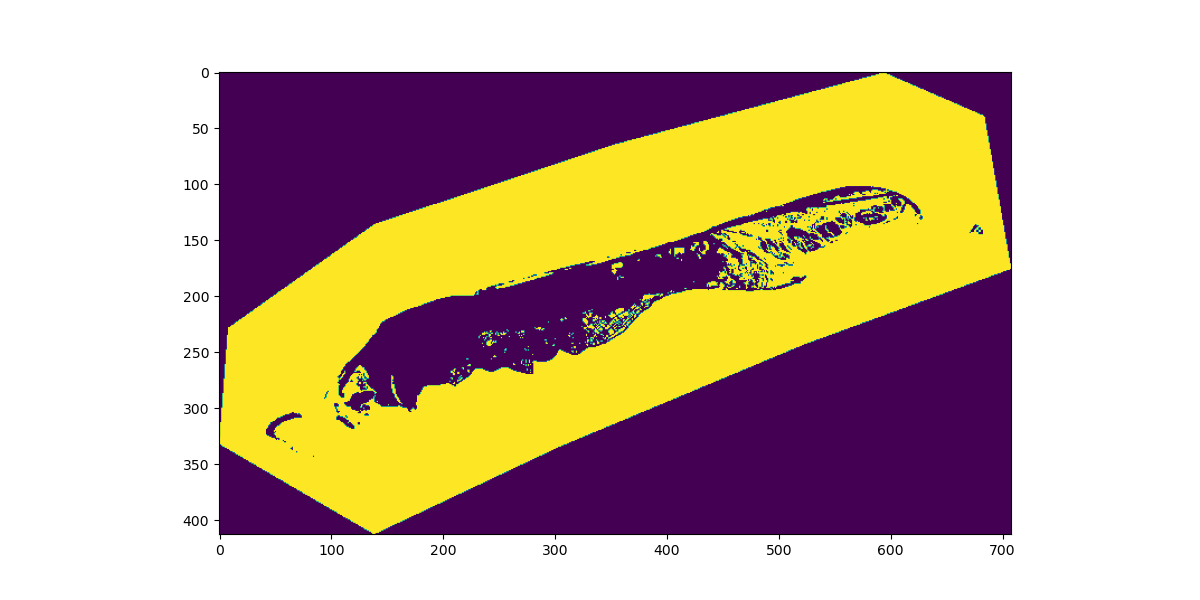

In [9]:
test_arr = np.zeros_like(ds_d.depth[:,:,0])
test_arr[np.where(ds_d.depth[:,:,0] <= 0.2)] = 1
fig, axes= plt.subplots(figsize=(12,6))
axes.imshow(test_arr)

# Clip masked area to island

<IPython.core.display.Javascript object>


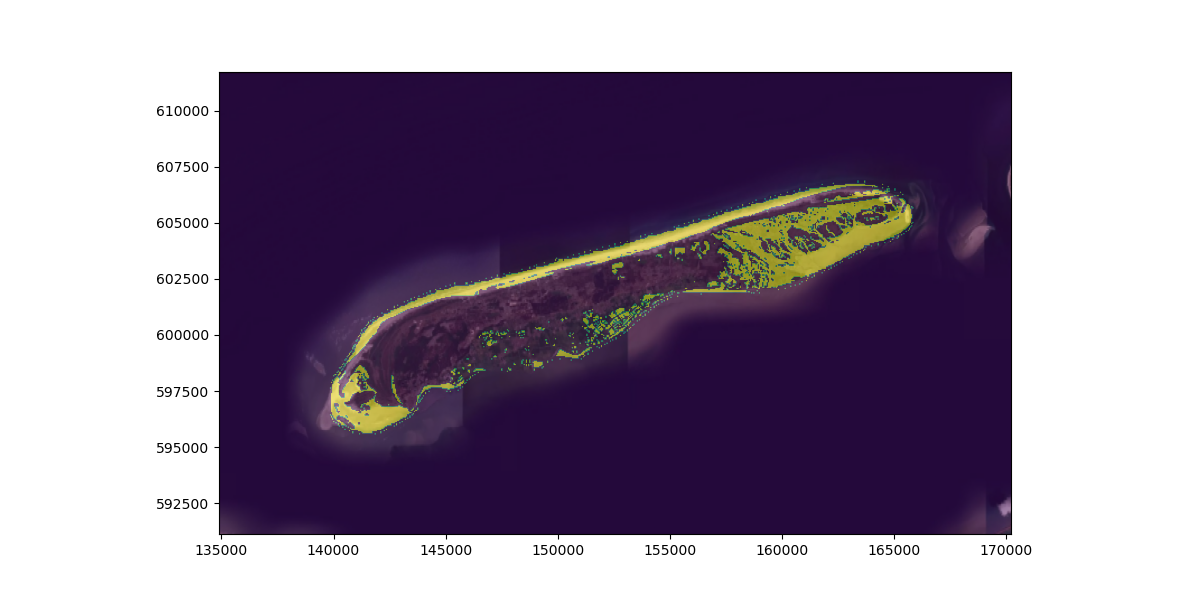

In [13]:
test_arr = np.zeros_like(ds_d.depth[:,:,0])

yel_filter = sat_2[:,:,-1]
yel_filter = cv2.resize(yel_filter, dsize=(test_arr.shape[1], test_arr.shape[0]), interpolation=cv2.INTER_CUBIC)

test_arr[(ds_d.depth[:,:,0]<=0.2) & (yel_filter>0)] = 1
fig, axes= plt.subplots(figsize=(12,6))
im_sat = axes.imshow(sat, extent=extent)
axes.imshow(test_arr, extent=extent, alpha=0.5)

# Add kwel to Terschelling (with blur)

<IPython.core.display.Javascript object>


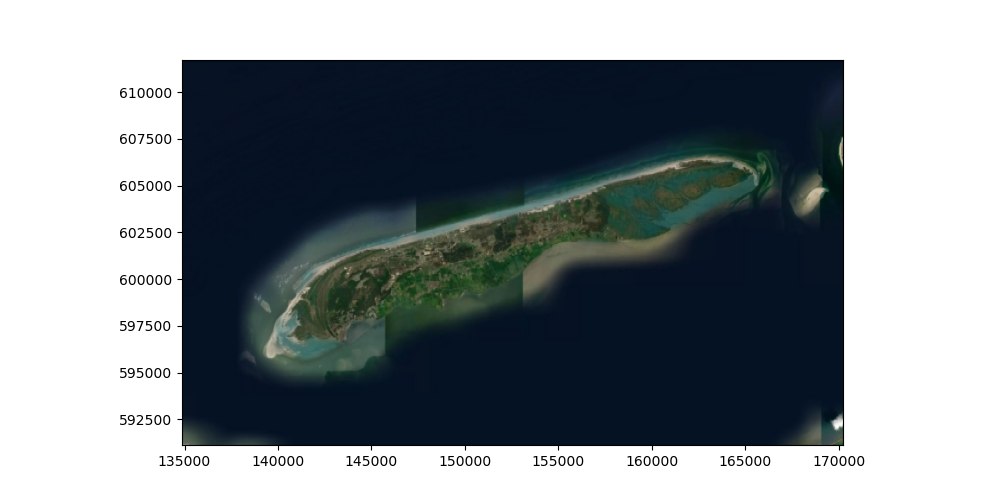

In [11]:
# Read image with water texture and rescale it to size of dataset
water_img = cv2.cvtColor(water_img, cv2.COLOR_BGR2RGB)
water_scaled = cv2.resize(water_img, dsize=(test_arr.shape[1], test_arr.shape[0]), interpolation=cv2.INTER_CUBIC)

# Create mask with locations of the pools of water, with alpha channel
mask = np.zeros(water_scaled.shape, np.uint8)
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGBA)
for i in range(4):
    mask[:,:,i] = test_arr * 255

# Add blur to the mask
blurred_img = cv2.GaussianBlur(mask, (21, 21), 0)

# Create array for pools with transparency added
output = np.zeros_like(water_scaled)
for i in range(3):
    output[:,:,i] = blurred_img[:,:,i] / 255 * water_scaled[:,:,i]
output = cv2.cvtColor(output, cv2.COLOR_RGB2RGBA)

# Add transparency from blurred_img to output
output[:,:,-1] = blurred_img[:,:,-1]

fig, axes = plt.subplots(figsize=(10,5))
axes.imshow(sat, extent=extent)
axes.imshow(output, extent=extent, alpha=0.6)

# Water level of wadsea (high water and low water)

<IPython.core.display.Javascript object>


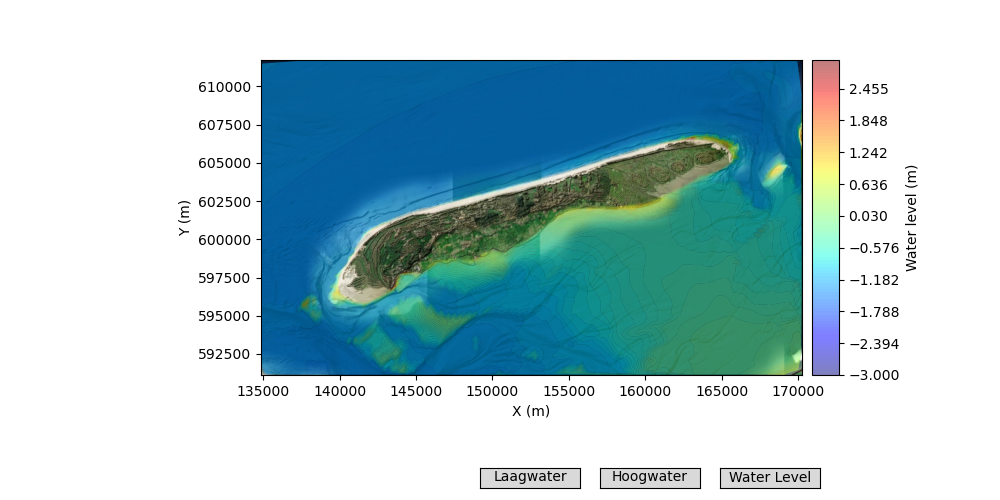

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [14]:
X1, Z1 = np.meshgrid(ds.x, ds.z)
X2, Y2 = np.meshgrid(ds.x, ds.y)

# Define initial parameters
init_x = 24
wl_levels = np.linspace(-3.0, 3.0, 100)

fig, axes = plt.subplots(figsize=(10,5), ncols=1)

# adjust the main plot to make room for the sliders
fig.subplots_adjust(left=0.2, bottom=0.25)

im_sat = axes.imshow(img_shade, extent=extent, zorder=1)
im_c_wl = axes.tricontourf(x_grid_t, y_grid_t, wl_t[400], levels=wl_levels, cmap='jet', extent=extent, alpha=0.5, zorder=2, antialiased=True)
im_sat_2 = axes.imshow(img_sat_2, extent=extent, zorder=3)

axes.set_xlabel('X (m)')
axes.set_ylabel('Y (m)')

# Create a `matplotlib.widgets.Button
buttonax = fig.add_axes([0.72, 0.025, 0.1, 0.04])
contour_button = Button(buttonax, 'Water Level', hovercolor='0.900')

buttonax_hw = fig.add_axes([0.6, 0.025, 0.1, 0.04])
hw_button = Button(buttonax_hw, 'Hoogwater', hovercolor='0.900')

buttonax_lw = fig.add_axes([0.48, 0.025, 0.1, 0.04])
lw_button = Button(buttonax_lw, 'Laagwater', hovercolor='0.900')

current = 'lw'
current_show = True
# Change the transparency for each individual element
def contour(event):
    global current_show
    global current
    if current_show:
        axes.cla()
        im_sat = axes.imshow(img_shade, extent=extent, zorder=1)
        axes.set_xlabel('X (m)')
        axes.set_ylabel('Y (m)')
        current_show = False
    elif current == 'lw' and not(current_show):
        im_c_wl = axes.tricontourf(x_grid_t, y_grid_t, wl_t[400], levels=wl_levels, cmap='jet', extent=extent, alpha=0.5, zorder=2, antialiased=True)
        im_sat_2 = axes.imshow(img_sat_2, extent=extent, zorder=3)
        axes.set_xlabel('X (m)')
        axes.set_ylabel('Y (m)')
        current_show = True
    elif current == 'hw' and not(current_show):
        im_c_wl = axes.tricontourf(x_grid_t, y_grid_t, wl_t[114], levels=wl_levels, cmap='jet', extent=extent, alpha=0.5, zorder=2, antialiased=True)
        im_sat_2 = axes.imshow(img_sat_2, extent=extent, zorder=3)
        axes.set_xlabel('X (m)')
        axes.set_ylabel('Y (m)')
        current_show = True
    fig.canvas.draw_idle()


def hoogwater(event):
    global current
    axes.cla()
    im_sat = axes.imshow(img_shade, extent=extent, zorder=1)
    im_c_wl = axes.tricontourf(x_grid_t, y_grid_t, wl_t[114], levels=wl_levels, cmap='jet', extent=extent, alpha=0.5, zorder=2, antialiased=True)
    im_sat_2 = axes.imshow(img_sat_2, extent=extent, zorder=3)
    axes.set_xlabel('X (m)')
    axes.set_ylabel('Y (m)')
    current = 'hw'
    fig.canvas.draw_idle()


def laagwater(event):
    global current
    axes.cla()
    im_sat = axes.imshow(img_shade, extent=extent, zorder=1)
    im_c_wl = axes.tricontourf(x_grid_t, y_grid_t, wl_t[400], levels=wl_levels, cmap='jet', extent=extent, alpha=0.5, zorder=2, antialiased=True)
    im_sat_2 = axes.imshow(img_sat_2, extent=extent, zorder=3)
    axes.set_xlabel('X (m)')
    axes.set_ylabel('Y (m)')
    current = 'lw'
    fig.canvas.draw_idle()


divider = make_axes_locatable(axes)
cax = divider.append_axes('right', size='5%', pad=0.10)
plt.colorbar(im_c_wl, cax=cax, label='Water level (m)')
    
reset_button.on_clicked(reset)
contour_button.on_clicked(contour)
hw_button.on_clicked(hoogwater)
lw_button.on_clicked(laagwater)

plt.show()